# Book Recommendation model

## Introduction

In this notebook I will demonestrate how to built a user based recommendation model using the Apache pyspark library. 


## About the Dataset Book crossing dataset

This dataset has been compiled by Cai-Nicolas Ziegler in 2004, and it comprises of three tables for users, books and ratings. Explicit ratings are expressed on a scale from 1-10 (higher values denoting higher appreciation) and implicit rating is expressed by 0

Link to dataset files
http://www2.informatik.uni-freiburg.de/~cziegler/BX/


> As this dataset has an explicit data, using the RMSE metric might be unappropriate. Another metric should be used like @MAP or @recall. However, I am still learning pyspark, so I decided to go with the RMSE then in the future modifications, I will use the other appropriate metrics.

## Connecting with Kaggle data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/booksdata/BX-Users.csv
/kaggle/input/booksdata/BX-Books.csv
/kaggle/input/booksdata/BX-Book-Ratings.csv
/kaggle/input/bookcrossing-dataset/Ratings.csv
/kaggle/input/bookcrossing-dataset/Books.csv
/kaggle/input/bookcrossing-dataset/Users.csv


## Importing libraries

In [2]:
#Making necesarry imports
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os, sys
import re
import seaborn as sns

## Reading data

In [3]:
#Loading data
books = pd.read_csv('../input/booksdata/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('../input/booksdata/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('../input/booksdata/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [4]:
#checking shapes of the datasets
print ("Book table has shape of: " + str(books.shape))
print ("Users table has shape of: " + str(users.shape))
print ("Ratings table has shape of: " + str(ratings.shape))

Book table has shape of: (271360, 8)
Users table has shape of: (278858, 3)
Ratings table has shape of: (1149780, 3)


In [5]:
display(books.head())

ISBN                                          bookTitle  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

             bookAuthor yearOfPublication                   publisher  \
0    Mark P. O. Morford              2002     Oxford University Press   
1  Richard Bruce Wright              2001       HarperFlamingo Canada   
2          Carlo D'Este              1991             HarperPerennial   
3      Gina Bari Kolata              1999        Farrar Straus Giroux   
4       E. J. W. Barber              1999  W. W. Norton &amp; Company   

                                           imageUrlS  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                           imageUrlM  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                           imageUrlL  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...  
3  http://images.amazon.com/images/P/0374157065.0...  
4  http://images.amazon.com/images/P/0393045218.0...

We can drop the unused columns from the books dataframe which is (**imageUrlS**, **imageUrlM**, **imageUrlL**), we won't use them

In [6]:
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'], axis = 1, inplace=True)

In [7]:
display(books.head())

ISBN                                          bookTitle  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

             bookAuthor yearOfPublication                   publisher  
0    Mark P. O. Morford              2002     Oxford University Press  
1  Richard Bruce Wright              2001       HarperFlamingo Canada  
2          Carlo D'Este              1991             HarperPerennial  
3      Gina Bari Kolata              1999        Farrar Straus Giroux  
4       E. J. W. Barber              1999  W. W. Norton &amp; Company

## 1. Books table
### 1.1 Data cleaning

In this stage, I will check each column and do some cleaning as a preparation to merge the data.

In [8]:
# check types 
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

### 1.1.a yearOfPublication column

In [9]:
# change yearOfPublication into int
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Have a string of 'DK Publishing Inc' in the year of publication, need to investigate this 


In [10]:
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

ISBN                                          bookTitle  \
209538  078946697X  DK Readers: Creating the X-Men, How It All Beg...   
221678  0789466953  DK Readers: Creating the X-Men, How Comic Book...   

       bookAuthor  yearOfPublication  \
209538       2000  DK Publishing Inc   
221678       2000  DK Publishing Inc   

                                                publisher  
209538  http://images.amazon.com/images/P/078946697X.0...  
221678  http://images.amazon.com/images/P/0789466953.0...

In [11]:
#From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [12]:
#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [13]:
#rechecking
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]
#corrections done

ISBN                                          bookTitle  \
209538  078946697X  DK Readers: Creating the X-Men, How It All Beg...   
221678  0789466953  DK Readers: Creating the X-Men, How Comic Book...   

                bookAuthor yearOfPublication          publisher  
209538  Michael Teitelbaum              2000  DK Publishing Inc  
221678       James Buckley              2000  DK Publishing Inc

In [14]:
pd.set_option('display.max_colwidth', -1)

In [15]:
#investigating the rows having 'Gallimard' as yearOfPublication
books.loc[books.yearOfPublication == 'Gallimard',:]

ISBN  \
220731  2070426769   

                                                                       bookTitle  \
220731  Peuple du ciel, suivi de 'Les Bergers\";Jean-Marie Gustave Le ClÃ?Â©zio"   

       bookAuthor yearOfPublication  \
220731  2003       Gallimard          

                                                           publisher  
220731  http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg

In [16]:
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [17]:
#rechecking
books.loc[(books.ISBN == '2070426769'),:]
#corrections done

ISBN                              bookTitle  \
220731  2070426769  Peuple du ciel, suivi de 'Les Bergers   

                             bookAuthor yearOfPublication  publisher  
220731  Jean-Marie Gustave Le ClÃ?Â©zio  2003              Gallimard

In [18]:
books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce')

In [19]:
print (books['yearOfPublication'].unique())
#Now it can be seen that yearOfPublication has all values as integers

[2002 2001 1991 1999 2000 1993 1996 1988 2004 1998 1994 2003 1997 1983
 1979 1995 1982 1985 1992 1986 1978 1980 1952 1987 1990 1981 1989 1984
    0 1968 1961 1958 1974 1976 1971 1977 1975 1965 1941 1970 1962 1973
 1972 1960 1966 1920 1956 1959 1953 1951 1942 1963 1964 1969 1954 1950
 1967 2005 1957 1940 1937 1955 1946 1936 1930 2011 1925 1948 1943 1947
 1945 1923 2020 1939 1926 1938 2030 1911 1904 1949 1932 1928 1929 1927
 1931 1914 2050 1934 1910 1933 1902 1924 1921 1900 2038 2026 1944 1917
 1901 2010 1908 1906 1935 1806 2021 2012 2006 1909 2008 1378 1919 1922
 1897 2024 1376 2037]


As resulted from the above value 0 is invalid and as this dataset was published in 2004, I have assumed the the years after 2006 to be invalid keeping some margin in case dataset was updated thereafer setting invalid years as NaN

In [20]:
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN

In [21]:
#replacing NaNs with mean value of yearOfPublication
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)

In [22]:
#rechecking
books.yearOfPublication.isnull().sum()
#No NaNs

0

In [23]:
#resetting the dtype as int32
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

### 1.1.b publisher column

In [24]:
books.loc[books.publisher.isnull(),:]

ISBN        bookTitle       bookAuthor  yearOfPublication  \
128890  193169656X  Tyrant Moon      Elaine Corvidae  2002                
129037  1931696993  Finders Keepers  Linnea Sinclair  2001                

       publisher  
128890  NaN       
129037  NaN

We have 2 Nas needs processing. I will investigate if those two observations have a clue in other incidents.

In [25]:
books.loc[(books.bookTitle == 'Tyrant Moon'),:]

ISBN    bookTitle       bookAuthor  yearOfPublication publisher
128890  193169656X  Tyrant Moon  Elaine Corvidae  2002               NaN

In [26]:
# do the same for the other book title
books.loc[(books.bookTitle == 'Finders Keepers'),:]

ISBN        bookTitle        bookAuthor  yearOfPublication  \
10799   082177364X  Finders Keepers  Fern Michaels     2002                
42019   0070465037  Finders Keepers  Barbara Nickolae  1989                
58264   0688118461  Finders Keepers  Emily Rodda       1993                
66678   1575663236  Finders Keepers  Fern Michaels     1998                
129037  1931696993  Finders Keepers  Linnea Sinclair   2001                
134309  0156309505  Finders Keepers  Will              1989                
173473  0973146907  Finders Keepers  Sean M. Costello  2002                
195885  0061083909  Finders Keepers  Sharon Sala       2003                
211874  0373261160  Finders Keepers  Elizabeth Travis  1993                

                                publisher  
10799   Zebra Books                        
42019   McGraw-Hill Companies              
58264   Harpercollins Juvenile Books       
66678   Kensington Publishing Corporation  
129037  NaN                                
134309  Voyager Books                      
173473  Red Tower Publications             
195885  HarperTorch                        
211874  Worldwide Library

In [27]:
# search by book author to find any patterns
books.loc[(books.bookAuthor == 'Elaine Corvidae'), :]

ISBN         bookTitle       bookAuthor  yearOfPublication  \
126762  1931696934  Winter's Orphans  Elaine Corvidae  2001                
128890  193169656X  Tyrant Moon       Elaine Corvidae  2002                
129001  0759901880  Wolfkin           Elaine Corvidae  2001                

                      publisher  
126762  Novelbooks               
128890  NaN                      
129001  Hard Shell Word Factory

In [28]:
books.loc[(books.bookAuthor == 'Linnea Sinclair'), :]

ISBN        bookTitle       bookAuthor  yearOfPublication  \
129037  1931696993  Finders Keepers  Linnea Sinclair  2001                

       publisher  
129037  NaN

In [29]:
#since there is nothing in common to infer publisher for NaNs, replacing these with 'other
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'

## 2 Users table


In [30]:
users.shape
display(users.head())

userID                            Location   Age
0  1       nyc, new york, usa                 NaN  
1  2       stockton, california, usa           18.0
2  3       moscow, yukon territory, russia    NaN  
3  4       porto, v.n.gaia, portugal           17.0
4  5       farnborough, hants, united kingdom NaN

In [31]:
users.dtypes

userID      int64  
Location    object 
Age         float64
dtype: object

### 2.1 Data cleaning

### 2.1.a userId column

In [32]:
users.userID.values

array([     1,      2,      3, ..., 278856, 278857, 278858])

### 2.1.b Age column

In [33]:
print (sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

userID has invalid values like nan!!, 140!!!, 189!!!, 223!!!

Steps to handle those non-logical values are: 

1. Replace the non-logic values with `np.NaN` for values greater than 5 and less than 90.

2. Replace NaN value with the mean

3. Setting the column type into int32.

4. Reshaping the column

In [34]:
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

In [35]:
#replacing NaNs with mean
users.Age = users.Age.fillna(users.Age.mean())

In [36]:
#setting the data type as int
users.Age = users.Age.astype(np.int32)

In [37]:
#rechecking
print (sorted(users.Age.unique()))


[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


## 3. Ratings table

In [38]:
print(ratings.shape)
display(ratings.head())

(1149780, 3)


userID        ISBN  bookRating
0  276725  034545104X  0         
1  276726  0155061224  5         
2  276727  0446520802  0         
3  276729  052165615X  3         
4  276729  0521795028  6

In [39]:
#ratings dataset will have n_users*n_books entries if every user rated every item, this shows that the dataset is very sparse
n_users = users.shape[0]
n_books = books.shape[0]
print (n_users * n_books)

75670906880


In [40]:
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [41]:
#ratings dataset should have books only which exist in our books dataset, unless new books are added to books dataset
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

In [42]:
print (ratings.shape)
print (ratings_new.shape)


(1149780, 3)
(1031136, 3)


It can be seen that many rows having book ISBN not part of books dataset got dropped off

In [43]:
#ratings dataset should have ratings from users which exist in users dataset, unless new users are added to users dataset
ratings = ratings[ratings.userID.isin(users.userID)]

In [44]:
print ("Ratings table has shape of: " + str(ratings.shape))
print ("New_ratings table has shape of: " + str(ratings_new.shape))
#no new users added, hence we will go with above dataset ratings_new (1031136, 3)

Ratings table has shape of: (1149780, 3)
New_ratings table has shape of: (1031136, 3)


In [45]:

print ("number of users: " + str(n_users))
print ("number of books: " + str(n_books))

number of users: 278858
number of books: 271360


In [46]:
#Sparsity of dataset in %

sparsity=1.0-len(ratings_new)/float(n_users*n_books)
print ('The sparsity level of Book Crossing dataset is ' +  str(sparsity*100) + ' %')

The sparsity level of Book Crossing dataset is 99.99863734155898 %


As quoted in the description of the dataset. BX-Book-Ratings contains the book rating information. Ratings are either explicit, expressed on a scale from 1-10 higher values denoting higher appreciation, or implicit, expressed by 0

In [47]:
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [48]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]

In [49]:
#checking shapes
print ('ratings_new dataset shape is ' + str(ratings_new.shape))
print ('ratings_explicit dataset shape is ' + str(ratings_explicit.shape))
print ('ratings_implicit dataset shape is ' + str(ratings_implicit.shape))

ratings_new dataset shape is (1031136, 3)
ratings_explicit dataset shape is (383842, 3)
ratings_implicit dataset shape is (647294, 3)


In [50]:
display(ratings_explicit.head())

userID        ISBN  bookRating
1   276726  0155061224  5         
3   276729  052165615X  3         
4   276729  0521795028  6         
8   276744  038550120X  7         
16  276747  0060517794  9

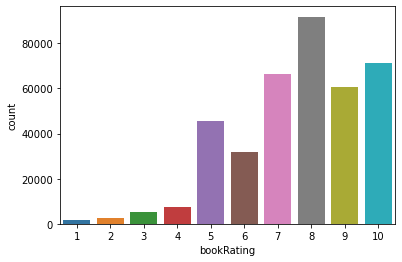

In [51]:
#plotting count of bookRating
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()


It can be seen that higher ratings are more common amongst users and rating 8 has been rated highest number of times

## Recommender build

## Popularity model

A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.
Ps. The main objective of a recommender system is to leverage the long-tail items to the users with very specific interests, which goes far beyond this simple technique.


In [52]:
ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['bookRating'].sum())
top10 = ratings_count.sort_values('bookRating', ascending = False).head(10)
print ("Following books are recommended: ")
top10.merge(books, left_index = True, right_on = 'ISBN')

Following books are recommended: 


bookRating        ISBN  \
408   5787        0316666343   
748   4108        0385504209   
522   3134        0312195516   
2143  2798        059035342X   
356   2595        0142001740   
26    2551        0971880107   
1105  2524        0060928336   
706   2402        0446672211   
231   2219        0452282152   
118   2179        0671027360   

                                                             bookTitle  \
408   The Lovely Bones: A Novel                                          
748   The Da Vinci Code                                                  
522   The Red Tent (Bestselling Backlist)                                
2143  Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))   
356   The Secret Life of Bees                                            
26    Wild Animus                                                        
1105  Divine Secrets of the Ya-Ya Sisterhood: A Novel                    
706   Where the Heart Is (Oprah's Book Club (Paperback))                 
231   Girl with a Pearl Earring                                          
118   Angels &amp; Demons                                                

           bookAuthor  yearOfPublication               publisher  
408   Alice Sebold     2002               Little, Brown           
748   Dan Brown        2003               Doubleday               
522   Anita Diamant    1998               Picador USA             
2143  J. K. Rowling    1999               Arthur A. Levine Books  
356   Sue Monk Kidd    2003               Penguin Books           
26    Rich Shapero     2004               Too Far                 
1105  Rebecca Wells    1997               Perennial               
706   Billie Letts     1998               Warner Books            
231   Tracy Chevalier  2001               Plume Books             
118   Dan Brown        2001               Pocket Star

## Collaborative Filtering Based model

In [53]:
display(ratings_explicit.head())

userID        ISBN  bookRating
1   276726  0155061224  5         
3   276729  052165615X  3         
4   276729  0521795028  6         
8   276744  038550120X  7         
16  276747  0060517794  9

## Install pyspark

In [54]:
!pip install pyspark

     |████████████████████████████████| 204.7 MB 21 kB/s s eta 0:00:01
     |████████████████████████████████| 198 kB 57.0 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=8bbdb7e8cf8ef1019beece6790218c57426957b445b26ececdef8de7dcef9831
  Stored in directory: /root/.cache/pip/wheels/4e/c5/36/aef1bb711963a619063119cc032176106827a129c0be20e301
Successfully built pyspark


In [55]:
import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator


In [56]:
# convert into spark dataframe
# spark.conf.set("spark.sql.excution.arrow.enabled", "true")

spark = SparkSession.builder.appName('bookRecommender').getOrCreate()



In [57]:
mySchema = StructType([ StructField("userID", IntegerType(), True)\
                        ,StructField("ISBN", StringType(), True)\
                        ,StructField("bookRating", IntegerType(), True)])

In [58]:
df_1 = spark.createDataFrame(ratings_explicit, schema=mySchema)

In [59]:
type(df_1)

pyspark.sql.dataframe.DataFrame

In [60]:
sp_ratings_df = df_1.cache()

In [61]:
display(sp_ratings_df.show(10))

+------+----------+----------+
|userID|      ISBN|bookRating|
+------+----------+----------+
|276726|0155061224|         5|
|276729|052165615X|         3|
|276729|0521795028|         6|
|276744|038550120X|         7|
|276747|0060517794|         9|
|276747|0671537458|         9|
|276747|0679776818|         8|
|276747|0943066433|         7|
|276747|1885408226|         7|
|276748|0747558167|         6|
+------+----------+----------+
only showing top 10 rows



None

## Converting String to index
Before making an ALS model it needs to be clear that ALS only accepts integer value as parameters. Hence we need to convert asin and reviewerID column in index form. The books table doesn't have a book id; however, it does have ISBN number. I will consider ISBN as an item-id as each book has a unique number. 

I would use the `StringIndexer` class from pyspark.ml module to convert the ISBN from string into index so I can use it building the ALS model.

In [62]:

from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

labelIndexer = StringIndexer(inputCol="ISBN", outputCol="ISBN_Index")
labelIndexerModel = labelIndexer.fit(sp_ratings_df)
indexed = labelIndexerModel.transform(sp_ratings_df)

In [63]:
indexed.show(5)

+------+----------+----------+----------+
|userID|      ISBN|bookRating|ISBN_Index|
+------+----------+----------+----------+
|276726|0155061224|         5|   58420.0|
|276729|052165615X|         3|   87191.0|
|276729|0521795028|         6|   87208.0|
|276744|038550120X|         7|     216.0|
|276747|0060517794|         9|    1070.0|
+------+----------+----------+----------+
only showing top 5 rows



In [64]:
labels = labelIndexerModel.labels


## Normalize rating 

**As rank and numIterations increase, RMSE decreases, given the same dataset. However, as dataset grows, RMSE increases**.

Now, one practice done to decrease RMSE and some other similar measures is to **normalize the values in ratings**. This works really well when you know in advance the minimum and maximum rating values.

Also, you should also consider using other measures other than RMSE. When doing Matrix Factorization, what I found useful is to **compute Frobenius Norm of ratings - predictions then divide by Frobenius Norm of ratings**. By doing this, you are getting the relative error of your predictions with respect to the original ratings.

In [65]:

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Iterating over columns to be scaled
for i in ["bookRating"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    indexed = pipeline.fit(indexed).transform(indexed).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("After Scaling :")
indexed.show(5)

After Scaling :
+------+----------+----------+----------+-----------------+
|userID|      ISBN|bookRating|ISBN_Index|bookRating_Scaled|
+------+----------+----------+----------+-----------------+
|276726|0155061224|         5|   58420.0|            0.444|
|276729|052165615X|         3|   87191.0|            0.222|
|276729|0521795028|         6|   87208.0|            0.556|
|276744|038550120X|         7|     216.0|            0.667|
|276747|0060517794|         9|    1070.0|            0.889|
+------+----------+----------+----------+-----------------+
only showing top 5 rows



In [66]:
indexed.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- bookRating: integer (nullable = true)
 |-- ISBN_Index: double (nullable = false)
 |-- bookRating_Scaled: double (nullable = true)



## Training model

## User-Based recommender model

In [67]:
(training, validation, test) = indexed.randomSplit([0.6, 0.2, 0.2])

A challenge for collaborative filtering is how to provide ratings to a new user (a user who has not provided any ratings at all). Some recommendation systems choose to provide new users with a set of default ratings (e.g., an average value across all ratings), while others choose to provide no ratings for new users. Spark's ALS algorithm yields a NaN (Not a Number) value when asked to provide a rating for a new user.

Using the ML Pipeline's CrossValidator with ALS is thus problematic, because cross validation involves dividing the training data into a set of folds (e.g., three sets) and then using those folds for testing and evaluating the parameters during the parameter grid search process. It is likely that some of the folds will contain users that are not in the other folds, and, as a result, ALS produces NaN values for those new users. When the CrossValidator uses the Evaluator (RMSE) to compute an error metric, the RMSE algorithm will return NaN. This will make all of the parameters in the parameter grid appear to be equally good (or bad).

You can read the discussion on Spark JIRA 14489 about this issue. There are proposed workarounds of having ALS provide default values or having RMSE drop NaN values. Both introduce potential issues. We have chosen to have RMSE drop NaN values. While this does not solve the underlying issue of ALS not predicting a value for a new user, it does provide some evaluation value. We manually implement the parameter grid search process using a for loop (below) and remove the NaN values before using RMSE.

In [73]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import *
import itertools
reg_eval=RegressionEvaluator(metricName="rmse",labelCol="bookRating_Scaled",predictionCol="prediction")


tolerance = 0.03
ranks = [4, 8, 12]
errors = [0, 0, 0]
models = [0, 0, 0]
err = 0
min_error = float('inf')
best_rank = -1
als = ALS(maxIter=5, regParam=0.01, 
          userCol="userID", itemCol="ISBN_Index", ratingCol="bookRating_Scaled",
          coldStartStrategy="drop")

for rank in ranks:
  # Set the rank here:
  als.setRank(5)
  # Create the model with these parameters.
  model = als.fit(training)
  # Run the model to create a prediction. Predict against the validation_df.
  predict_df = model.transform(validation)

  # Remove NaN values from prediction (due to SPARK-14489)
  predicted_ratings_df = predict_df.filter(predict_df.prediction != float('nan'))

  # Run the previously created RMSE evaluator, reg_eval, on the predicted_ratings_df DataFrame
  error = reg_eval.evaluate(predict_df)
  errors[err] = error
  models[err] = model
  print ('For rank %s the RMSE is %s' % (rank, error))
  if error < min_error:
    min_error = error
    best_rank = err
  err += 1

als.setRank(ranks[best_rank])
print ('The best model was trained with rank %s' % ranks[best_rank])
my_model = models[best_rank]


For rank 4 the RMSE is 0.7601499380948791
For rank 8 the RMSE is 0.7601499380948791
For rank 12 the RMSE is 0.7601499380948791
The best model was trained with rank 4


Looking at the RMSE for the results predicted by the model versus the values in the test set is one way to evalute the quality of our model. Another way to evaluate the model is to evaluate the error from a test set where every rating is the average rating for the training set.

In [74]:
# In ML Pipelines, this next step has a bug that produces unwanted NaN values. We
# have to filter them out. See https://issues.apache.org/jira/browse/SPARK-14489
predict_df = my_model.transform(test)

# Remove NaN values from prediction (due to SPARK-14489)
predicted_test_df = predict_df.filter(predict_df.prediction != float('nan'))

# Run the previously created RMSE evaluator, reg_eval, on the predicted_test_df DataFrame
test_RMSE = reg_eval.evaluate(predicted_test_df)

print('The model had a RMSE on the test set of {0}'.format(test_RMSE))

The model had a RMSE on the test set of 0.7630612712934595


In [75]:
predicted_test_df.show(3)

+------+----------+----------+----------+-----------------+-----------+
|userID|      ISBN|bookRating|ISBN_Index|bookRating_Scaled| prediction|
+------+----------+----------+----------+-----------------+-----------+
|268262|0060977493|        10|     148.0|              1.0| 0.70812607|
|209147|0060977493|         8|     148.0|            0.778|-0.83032537|
|263163|0060977493|         7|     148.0|            0.667| 0.35302472|
+------+----------+----------+----------+-----------------+-----------+
only showing top 3 rows



In [76]:
recs = (
my_model.recommendForAllUsers(3)
)

## Converting back to string form
As seen in above image the results are in integer form we need to convert it back to its original name.The code is little bit longer given so many conversions.

In [78]:
from pyspark.sql.functions import array, col, lit, struct

n = 3  # Same as numItems

book_labels_ = array(*[lit(x) for x in labels])
recommendations = array(*[struct(
    book_labels_[col("recommendations")[i]["ISBN_Index"]].alias("ISBN"),
    col("recommendations")[i]["rating"].alias("rating")
) for i in range(n)])

recs.withColumn("recommendations", recommendations)

DataFrame[userID: int, recommendations: array<struct<ISBN:string,rating:float>>]

Get the recommendation into a JSON format:

In [81]:
import json
recss = recs.toJSON()

for row in recss.collect():
#     #json string
# #     print(row) 

#     #json object
    line = json.loads(row) 
    print(line) 

{'userID': 496, 'recommendations': [{'ISBN_Index': 5898, 'rating': 1.899708}, {'ISBN_Index': 14292, 'rating': 1.8456646}, {'ISBN_Index': 31604, 'rating': 1.8256291}]}
{'userID': 1591, 'recommendations': [{'ISBN_Index': 23796, 'rating': 2.12465}, {'ISBN_Index': 5554, 'rating': 2.0427582}, {'ISBN_Index': 23655, 'rating': 1.9163176}]}
{'userID': 3175, 'recommendations': [{'ISBN_Index': 9442, 'rating': 2.490773}, {'ISBN_Index': 8571, 'rating': 2.0910995}, {'ISBN_Index': 2690, 'rating': 2.0318394}]}
{'userID': 3918, 'recommendations': [{'ISBN_Index': 2827, 'rating': 2.396207}, {'ISBN_Index': 14300, 'rating': 2.3186543}, {'ISBN_Index': 10433, 'rating': 2.2921195}]}
{'userID': 4900, 'recommendations': [{'ISBN_Index': 34572, 'rating': 2.2097354}, {'ISBN_Index': 6099, 'rating': 1.861619}, {'ISBN_Index': 2754, 'rating': 1.748357}]}
{'userID': 6336, 'recommendations': [{'ISBN_Index': 34572, 'rating': 1.7951552}, {'ISBN_Index': 6099, 'rating': 1.7845955}, {'ISBN_Index': 18424, 'rating': 1.4859807}

{'userID': 200315, 'recommendations': [{'ISBN_Index': 12782, 'rating': 2.5669956}, {'ISBN_Index': 13721, 'rating': 2.4079297}, {'ISBN_Index': 9442, 'rating': 2.398395}]}
{'userID': 200851, 'recommendations': [{'ISBN_Index': 13419, 'rating': 1.0068951}, {'ISBN_Index': 7044, 'rating': 0.93285096}, {'ISBN_Index': 26575, 'rating': 0.8944004}]}
{'userID': 201011, 'recommendations': [{'ISBN_Index': 2827, 'rating': 0.79590136}, {'ISBN_Index': 18374, 'rating': 0.75394386}, {'ISBN_Index': 10433, 'rating': 0.7385832}]}
{'userID': 201768, 'recommendations': [{'ISBN_Index': 12137, 'rating': 3.8158958}, {'ISBN_Index': 33117, 'rating': 2.8173707}, {'ISBN_Index': 10529, 'rating': 2.7709875}]}
{'userID': 204567, 'recommendations': [{'ISBN_Index': 12183, 'rating': 1.1552186}, {'ISBN_Index': 6650, 'rating': 1.1374474}, {'ISBN_Index': 7647, 'rating': 1.1170456}]}
{'userID': 204822, 'recommendations': [{'ISBN_Index': 9960, 'rating': 4.164836}, {'ISBN_Index': 3246, 'rating': 3.8135598}, {'ISBN_Index': 9786

{'userID': 208390, 'recommendations': [{'ISBN_Index': 2486, 'rating': 1.4745612}, {'ISBN_Index': 18100, 'rating': 1.4205847}, {'ISBN_Index': 35861, 'rating': 1.3756392}]}
{'userID': 209186, 'recommendations': [{'ISBN_Index': 34572, 'rating': 3.2180314}, {'ISBN_Index': 2754, 'rating': 3.054553}, {'ISBN_Index': 16348, 'rating': 2.7281635}]}
{'userID': 211152, 'recommendations': [{'ISBN_Index': 8571, 'rating': 3.8661616}, {'ISBN_Index': 9442, 'rating': 3.8296866}, {'ISBN_Index': 4727, 'rating': 3.8229494}]}
{'userID': 211593, 'recommendations': [{'ISBN_Index': 10529, 'rating': 2.2461483}, {'ISBN_Index': 7352, 'rating': 2.0127556}, {'ISBN_Index': 18374, 'rating': 1.9836918}]}
{'userID': 213150, 'recommendations': [{'ISBN_Index': 33117, 'rating': 2.1460845}, {'ISBN_Index': 8286, 'rating': 2.0138068}, {'ISBN_Index': 13828, 'rating': 1.9654208}]}
{'userID': 213921, 'recommendations': [{'ISBN_Index': 21297, 'rating': 1.8690411}, {'ISBN_Index': 12332, 'rating': 1.6931123}, {'ISBN_Index': 4131, 

{'userID': 30416, 'recommendations': [{'ISBN_Index': 12625, 'rating': 1.9321169}, {'ISBN_Index': 12938, 'rating': 1.9114143}, {'ISBN_Index': 10932, 'rating': 1.855963}]}
{'userID': 30980, 'recommendations': [{'ISBN_Index': 10231, 'rating': 1.832343}, {'ISBN_Index': 6491, 'rating': 1.6845692}, {'ISBN_Index': 11780, 'rating': 1.6377853}]}
{'userID': 31322, 'recommendations': [{'ISBN_Index': 12137, 'rating': 2.340509}, {'ISBN_Index': 33117, 'rating': 2.096583}, {'ISBN_Index': 10529, 'rating': 1.8908757}]}
{'userID': 31377, 'recommendations': [{'ISBN_Index': 10529, 'rating': 1.4088521}, {'ISBN_Index': 7352, 'rating': 1.3594054}, {'ISBN_Index': 8845, 'rating': 1.3396602}]}
{'userID': 31419, 'recommendations': [{'ISBN_Index': 9960, 'rating': 2.761226}, {'ISBN_Index': 26575, 'rating': 2.3794382}, {'ISBN_Index': 16113, 'rating': 2.240401}]}
{'userID': 33264, 'recommendations': [{'ISBN_Index': 24983, 'rating': 2.6951923}, {'ISBN_Index': 33117, 'rating': 2.5674157}, {'ISBN_Index': 8083, 'rating'

{'userID': 156642, 'recommendations': [{'ISBN_Index': 9960, 'rating': 1.5828501}, {'ISBN_Index': 9786, 'rating': 1.4039186}, {'ISBN_Index': 12332, 'rating': 1.3147365}]}
{'userID': 156856, 'recommendations': [{'ISBN_Index': 8810, 'rating': 2.839799}, {'ISBN_Index': 7637, 'rating': 2.7018478}, {'ISBN_Index': 5292, 'rating': 2.6185782}]}
{'userID': 158917, 'recommendations': [{'ISBN_Index': 13419, 'rating': 2.165192}, {'ISBN_Index': 4763, 'rating': 1.6423771}, {'ISBN_Index': 17700, 'rating': 1.6078546}]}
{'userID': 159316, 'recommendations': [{'ISBN_Index': 12137, 'rating': 2.0950763}, {'ISBN_Index': 17700, 'rating': 1.9977573}, {'ISBN_Index': 13419, 'rating': 1.9782939}]}
{'userID': 159858, 'recommendations': [{'ISBN_Index': 13419, 'rating': 3.7332168}, {'ISBN_Index': 12964, 'rating': 3.4264102}, {'ISBN_Index': 7086, 'rating': 2.780295}]}
{'userID': 162419, 'recommendations': [{'ISBN_Index': 10529, 'rating': 3.3921301}, {'ISBN_Index': 7352, 'rating': 3.218677}, {'ISBN_Index': 42659, 'ra

{'userID': 118431, 'recommendations': [{'ISBN_Index': 34572, 'rating': 1.2789786}, {'ISBN_Index': 9191, 'rating': 1.2735294}, {'ISBN_Index': 7987, 'rating': 1.240896}]}
{'userID': 118628, 'recommendations': [{'ISBN_Index': 5294, 'rating': 2.7813034}, {'ISBN_Index': 9960, 'rating': 2.7294354}, {'ISBN_Index': 21297, 'rating': 2.7219882}]}
{'userID': 119324, 'recommendations': [{'ISBN_Index': 12782, 'rating': 1.7109293}, {'ISBN_Index': 12183, 'rating': 1.6789935}, {'ISBN_Index': 20988, 'rating': 1.6611663}]}
{'userID': 119737, 'recommendations': [{'ISBN_Index': 34572, 'rating': 1.6628897}, {'ISBN_Index': 12724, 'rating': 1.2621788}, {'ISBN_Index': 2754, 'rating': 1.2598219}]}
{'userID': 120669, 'recommendations': [{'ISBN_Index': 13419, 'rating': 2.2038095}, {'ISBN_Index': 10319, 'rating': 2.0947893}, {'ISBN_Index': 12964, 'rating': 1.9551314}]}
{'userID': 123292, 'recommendations': [{'ISBN_Index': 11417, 'rating': 1.847928}, {'ISBN_Index': 2754, 'rating': 1.7363582}, {'ISBN_Index': 4890, 

{'userID': 77971, 'recommendations': [{'ISBN_Index': 33117, 'rating': 2.2699955}, {'ISBN_Index': 14292, 'rating': 2.13926}, {'ISBN_Index': 17714, 'rating': 2.1307783}]}
{'userID': 78637, 'recommendations': [{'ISBN_Index': 6099, 'rating': 4.257084}, {'ISBN_Index': 34572, 'rating': 3.7625344}, {'ISBN_Index': 10112, 'rating': 3.7027996}]}
{'userID': 78746, 'recommendations': [{'ISBN_Index': 14074, 'rating': 1.6025631}, {'ISBN_Index': 13828, 'rating': 1.5792083}, {'ISBN_Index': 9002, 'rating': 1.3821017}]}
{'userID': 79525, 'recommendations': [{'ISBN_Index': 17655, 'rating': 2.308618}, {'ISBN_Index': 25539, 'rating': 2.2940042}, {'ISBN_Index': 31268, 'rating': 2.2506044}]}
{'userID': 79527, 'recommendations': [{'ISBN_Index': 34572, 'rating': 3.8133302}, {'ISBN_Index': 3024, 'rating': 3.7716775}, {'ISBN_Index': 2754, 'rating': 3.7264636}]}
{'userID': 81855, 'recommendations': [{'ISBN_Index': 33117, 'rating': 3.7040083}, {'ISBN_Index': 14292, 'rating': 2.6191542}, {'ISBN_Index': 10523, 'rati

{'userID': 248815, 'recommendations': [{'ISBN_Index': 23771, 'rating': 2.489023}, {'ISBN_Index': 18385, 'rating': 2.0535173}, {'ISBN_Index': 13828, 'rating': 2.0522075}]}
{'userID': 249977, 'recommendations': [{'ISBN_Index': 4969, 'rating': 1.3360333}, {'ISBN_Index': 45568, 'rating': 1.2593044}, {'ISBN_Index': 5198, 'rating': 1.2046196}]}
{'userID': 252282, 'recommendations': [{'ISBN_Index': 11225, 'rating': 1.6923757}, {'ISBN_Index': 40685, 'rating': 1.6093154}, {'ISBN_Index': 34572, 'rating': 1.5458403}]}
{'userID': 252909, 'recommendations': [{'ISBN_Index': 14300, 'rating': 1.8586167}, {'ISBN_Index': 4969, 'rating': 1.7481258}, {'ISBN_Index': 11417, 'rating': 1.7339869}]}
{'userID': 253346, 'recommendations': [{'ISBN_Index': 13419, 'rating': 2.3799105}, {'ISBN_Index': 10319, 'rating': 1.9259294}, {'ISBN_Index': 3659, 'rating': 1.6989918}]}
{'userID': 254383, 'recommendations': [{'ISBN_Index': 9960, 'rating': 1.906832}, {'ISBN_Index': 4969, 'rating': 1.8530855}, {'ISBN_Index': 10868,

{'userID': 239776, 'recommendations': [{'ISBN_Index': 34572, 'rating': 2.5842388}, {'ISBN_Index': 6099, 'rating': 2.3108206}, {'ISBN_Index': 8034, 'rating': 2.2409763}]}
{'userID': 240461, 'recommendations': [{'ISBN_Index': 6099, 'rating': 1.1469462}, {'ISBN_Index': 44358, 'rating': 1.1023006}, {'ISBN_Index': 11844, 'rating': 0.99962765}]}
{'userID': 241326, 'recommendations': [{'ISBN_Index': 33117, 'rating': 1.2614661}, {'ISBN_Index': 10529, 'rating': 1.0508039}, {'ISBN_Index': 10523, 'rating': 0.99015415}]}
{'userID': 243148, 'recommendations': [{'ISBN_Index': 16564, 'rating': 1.1402233}, {'ISBN_Index': 9666, 'rating': 0.9983912}, {'ISBN_Index': 5065, 'rating': 0.97143555}]}
{'userID': 243660, 'recommendations': [{'ISBN_Index': 34572, 'rating': 1.9837347}, {'ISBN_Index': 12724, 'rating': 1.5386653}, {'ISBN_Index': 21297, 'rating': 1.4547591}]}
{'userID': 243947, 'recommendations': [{'ISBN_Index': 10390, 'rating': 2.363589}, {'ISBN_Index': 12183, 'rating': 2.2868946}, {'ISBN_Index': 1

{'userID': 39700, 'recommendations': [{'ISBN_Index': 10529, 'rating': 2.4203568}, {'ISBN_Index': 15398, 'rating': 2.087471}, {'ISBN_Index': 17085, 'rating': 2.013424}]}
{'userID': 40483, 'recommendations': [{'ISBN_Index': 2827, 'rating': 0.28166988}, {'ISBN_Index': 2486, 'rating': 0.2709901}, {'ISBN_Index': 10397, 'rating': 0.26338896}]}
{'userID': 40521, 'recommendations': [{'ISBN_Index': 9442, 'rating': 1.7672392}, {'ISBN_Index': 9474, 'rating': 1.4121182}, {'ISBN_Index': 2690, 'rating': 1.3823923}]}
{'userID': 41667, 'recommendations': [{'ISBN_Index': 13419, 'rating': 2.7950656}, {'ISBN_Index': 8065, 'rating': 2.3411584}, {'ISBN_Index': 25477, 'rating': 2.3180122}]}
{'userID': 41718, 'recommendations': [{'ISBN_Index': 31268, 'rating': 2.3289313}, {'ISBN_Index': 12183, 'rating': 2.2507327}, {'ISBN_Index': 16362, 'rating': 2.2056267}]}
{'userID': 43275, 'recommendations': [{'ISBN_Index': 34572, 'rating': 2.3277442}, {'ISBN_Index': 2754, 'rating': 1.9971974}, {'ISBN_Index': 12724, 'rat

{'userID': 69749, 'recommendations': [{'ISBN_Index': 6099, 'rating': 3.2242692}, {'ISBN_Index': 34572, 'rating': 2.8948174}, {'ISBN_Index': 44358, 'rating': 2.6849198}]}
{'userID': 69759, 'recommendations': [{'ISBN_Index': 33117, 'rating': 1.4343494}, {'ISBN_Index': 14292, 'rating': 1.162185}, {'ISBN_Index': 25477, 'rating': 1.044807}]}
{'userID': 70435, 'recommendations': [{'ISBN_Index': 33117, 'rating': 3.6861286}, {'ISBN_Index': 10523, 'rating': 2.6801994}, {'ISBN_Index': 10529, 'rating': 2.6092846}]}
{'userID': 70733, 'recommendations': [{'ISBN_Index': 6099, 'rating': 2.3510578}, {'ISBN_Index': 34572, 'rating': 2.0980797}, {'ISBN_Index': 44358, 'rating': 2.0360157}]}
{'userID': 71618, 'recommendations': [{'ISBN_Index': 34572, 'rating': 3.0762825}, {'ISBN_Index': 11225, 'rating': 2.8834515}, {'ISBN_Index': 2754, 'rating': 2.843996}]}
{'userID': 71662, 'recommendations': [{'ISBN_Index': 9442, 'rating': 4.741423}, {'ISBN_Index': 2690, 'rating': 3.4544554}, {'ISBN_Index': 34572, 'ratin

{'userID': 240528, 'recommendations': [{'ISBN_Index': 6099, 'rating': 4.627132}, {'ISBN_Index': 24983, 'rating': 4.25508}, {'ISBN_Index': 33117, 'rating': 3.8276966}]}
{'userID': 240544, 'recommendations': [{'ISBN_Index': 9960, 'rating': 1.2755125}, {'ISBN_Index': 10231, 'rating': 0.99176055}, {'ISBN_Index': 6973, 'rating': 0.9740651}]}
{'userID': 242038, 'recommendations': [{'ISBN_Index': 12137, 'rating': 1.1610345}, {'ISBN_Index': 18888, 'rating': 0.9711424}, {'ISBN_Index': 23068, 'rating': 0.8818362}]}
{'userID': 242076, 'recommendations': [{'ISBN_Index': 21297, 'rating': 2.782625}, {'ISBN_Index': 23796, 'rating': 2.3580263}, {'ISBN_Index': 32376, 'rating': 2.272537}]}
{'userID': 242153, 'recommendations': [{'ISBN_Index': 11225, 'rating': 1.6108731}, {'ISBN_Index': 40685, 'rating': 1.5763041}, {'ISBN_Index': 13498, 'rating': 1.4928048}]}
{'userID': 242216, 'recommendations': [{'ISBN_Index': 6099, 'rating': 2.0406637}, {'ISBN_Index': 34572, 'rating': 2.0059927}, {'ISBN_Index': 10112,

{'userID': 161074, 'recommendations': [{'ISBN_Index': 26575, 'rating': 0.9585365}, {'ISBN_Index': 9960, 'rating': 0.94549316}, {'ISBN_Index': 5798, 'rating': 0.84124583}]}
{'userID': 163656, 'recommendations': [{'ISBN_Index': 9960, 'rating': 1.0908204}, {'ISBN_Index': 26575, 'rating': 1.0860434}, {'ISBN_Index': 12938, 'rating': 1.0776068}]}
{'userID': 164584, 'recommendations': [{'ISBN_Index': 11225, 'rating': 3.4025717}, {'ISBN_Index': 34572, 'rating': 3.2999935}, {'ISBN_Index': 16348, 'rating': 3.2286563}]}
{'userID': 164675, 'recommendations': [{'ISBN_Index': 6099, 'rating': 2.934367}, {'ISBN_Index': 12539, 'rating': 2.4867988}, {'ISBN_Index': 34572, 'rating': 2.2854955}]}
{'userID': 165389, 'recommendations': [{'ISBN_Index': 21297, 'rating': 0.7204913}, {'ISBN_Index': 4131, 'rating': 0.6764235}, {'ISBN_Index': 23796, 'rating': 0.67062485}]}
{'userID': 165706, 'recommendations': [{'ISBN_Index': 44467, 'rating': 2.8656588}, {'ISBN_Index': 9442, 'rating': 2.5628796}, {'ISBN_Index': 57

{'userID': 166017, 'recommendations': [{'ISBN_Index': 13419, 'rating': 3.3011026}, {'ISBN_Index': 10319, 'rating': 3.2569134}, {'ISBN_Index': 3659, 'rating': 2.7670102}]}
{'userID': 166341, 'recommendations': [{'ISBN_Index': 14292, 'rating': 1.6842182}, {'ISBN_Index': 4969, 'rating': 1.6826053}, {'ISBN_Index': 25539, 'rating': 1.6663342}]}
{'userID': 171491, 'recommendations': [{'ISBN_Index': 13828, 'rating': 2.603602}, {'ISBN_Index': 44467, 'rating': 2.4753375}, {'ISBN_Index': 14074, 'rating': 2.4006026}]}
{'userID': 171968, 'recommendations': [{'ISBN_Index': 31604, 'rating': 2.7783158}, {'ISBN_Index': 26483, 'rating': 2.750112}, {'ISBN_Index': 5294, 'rating': 2.7295675}]}
{'userID': 172575, 'recommendations': [{'ISBN_Index': 33117, 'rating': 2.3981826}, {'ISBN_Index': 23068, 'rating': 2.2009408}, {'ISBN_Index': 12137, 'rating': 2.0752156}]}
{'userID': 173347, 'recommendations': [{'ISBN_Index': 9442, 'rating': 2.7449784}, {'ISBN_Index': 5065, 'rating': 2.6487439}, {'ISBN_Index': 8810,

{'userID': 135141, 'recommendations': [{'ISBN_Index': 33117, 'rating': 3.4021425}, {'ISBN_Index': 14074, 'rating': 3.2513413}, {'ISBN_Index': 12849, 'rating': 2.8630419}]}
{'userID': 135766, 'recommendations': [{'ISBN_Index': 2827, 'rating': 2.3142068}, {'ISBN_Index': 15603, 'rating': 2.1994364}, {'ISBN_Index': 5280, 'rating': 2.1894202}]}
{'userID': 136118, 'recommendations': [{'ISBN_Index': 9442, 'rating': 1.1739987}, {'ISBN_Index': 34572, 'rating': 1.1139051}, {'ISBN_Index': 7987, 'rating': 1.005865}]}
{'userID': 136425, 'recommendations': [{'ISBN_Index': 8845, 'rating': 2.9441426}, {'ISBN_Index': 13828, 'rating': 2.6323197}, {'ISBN_Index': 26091, 'rating': 2.3692799}]}
{'userID': 136733, 'recommendations': [{'ISBN_Index': 33117, 'rating': 2.996974}, {'ISBN_Index': 10523, 'rating': 2.2872112}, {'ISBN_Index': 14292, 'rating': 2.150162}]}
{'userID': 137585, 'recommendations': [{'ISBN_Index': 13419, 'rating': 2.836655}, {'ISBN_Index': 23068, 'rating': 2.3980021}, {'ISBN_Index': 12964, 

{'userID': 80767, 'recommendations': [{'ISBN_Index': 33117, 'rating': 2.3789892}, {'ISBN_Index': 25539, 'rating': 2.2033474}, {'ISBN_Index': 24983, 'rating': 2.1757958}]}
{'userID': 81026, 'recommendations': [{'ISBN_Index': 9960, 'rating': 2.721316}, {'ISBN_Index': 5798, 'rating': 2.4549594}, {'ISBN_Index': 26575, 'rating': 2.442042}]}
{'userID': 81063, 'recommendations': [{'ISBN_Index': 8845, 'rating': 3.4490016}, {'ISBN_Index': 6684, 'rating': 2.7120857}, {'ISBN_Index': 4727, 'rating': 2.4705958}]}
{'userID': 81739, 'recommendations': [{'ISBN_Index': 9442, 'rating': 3.5513546}, {'ISBN_Index': 12782, 'rating': 2.8488023}, {'ISBN_Index': 4727, 'rating': 2.684604}]}
{'userID': 81865, 'recommendations': [{'ISBN_Index': 6099, 'rating': 3.0708787}, {'ISBN_Index': 44358, 'rating': 2.8103235}, {'ISBN_Index': 12539, 'rating': 2.4261174}]}
{'userID': 82360, 'recommendations': [{'ISBN_Index': 9442, 'rating': 2.528817}, {'ISBN_Index': 34572, 'rating': 2.077882}, {'ISBN_Index': 11052, 'rating': 1

{'userID': 85092, 'recommendations': [{'ISBN_Index': 5065, 'rating': 2.7200317}, {'ISBN_Index': 44467, 'rating': 2.6091945}, {'ISBN_Index': 20939, 'rating': 2.4052284}]}
{'userID': 85622, 'recommendations': [{'ISBN_Index': 12137, 'rating': 1.7639837}, {'ISBN_Index': 18888, 'rating': 1.5233216}, {'ISBN_Index': 23111, 'rating': 1.3453468}]}
{'userID': 86107, 'recommendations': [{'ISBN_Index': 34572, 'rating': 1.2001644}, {'ISBN_Index': 5898, 'rating': 1.1135964}, {'ISBN_Index': 14292, 'rating': 1.1129895}]}
{'userID': 86620, 'recommendations': [{'ISBN_Index': 18888, 'rating': 1.9378185}, {'ISBN_Index': 12938, 'rating': 1.8974564}, {'ISBN_Index': 5514, 'rating': 1.8689134}]}
{'userID': 91612, 'recommendations': [{'ISBN_Index': 2827, 'rating': 1.3359528}, {'ISBN_Index': 2486, 'rating': 1.2993761}, {'ISBN_Index': 10397, 'rating': 1.2787588}]}
{'userID': 92534, 'recommendations': [{'ISBN_Index': 12137, 'rating': 2.7728121}, {'ISBN_Index': 11417, 'rating': 2.2889564}, {'ISBN_Index': 33117, 'r

{'userID': 166926, 'recommendations': [{'ISBN_Index': 21039, 'rating': 1.2561202}, {'ISBN_Index': 17085, 'rating': 1.2130533}, {'ISBN_Index': 16886, 'rating': 1.1455163}]}
{'userID': 166927, 'recommendations': [{'ISBN_Index': 3659, 'rating': 1.1798717}, {'ISBN_Index': 18888, 'rating': 1.1330651}, {'ISBN_Index': 10319, 'rating': 1.1194012}]}
{'userID': 167275, 'recommendations': [{'ISBN_Index': 14074, 'rating': 2.5467935}, {'ISBN_Index': 17572, 'rating': 2.474815}, {'ISBN_Index': 12137, 'rating': 2.4200919}]}
{'userID': 167443, 'recommendations': [{'ISBN_Index': 12137, 'rating': 2.5885785}, {'ISBN_Index': 23111, 'rating': 2.4154372}, {'ISBN_Index': 8166, 'rating': 2.4028933}]}
{'userID': 168346, 'recommendations': [{'ISBN_Index': 6099, 'rating': 2.0631425}, {'ISBN_Index': 44358, 'rating': 1.8269382}, {'ISBN_Index': 12539, 'rating': 1.7167814}]}
{'userID': 169384, 'recommendations': [{'ISBN_Index': 9442, 'rating': 1.7268329}, {'ISBN_Index': 2690, 'rating': 1.5011256}, {'ISBN_Index': 1349

{'userID': 85993, 'recommendations': [{'ISBN_Index': 14292, 'rating': 2.9152734}, {'ISBN_Index': 12625, 'rating': 2.6397743}, {'ISBN_Index': 17714, 'rating': 2.6361527}]}
{'userID': 87317, 'recommendations': [{'ISBN_Index': 3754, 'rating': 2.5760636}, {'ISBN_Index': 11523, 'rating': 2.2763672}, {'ISBN_Index': 12144, 'rating': 2.2338762}]}
{'userID': 89803, 'recommendations': [{'ISBN_Index': 34572, 'rating': 2.1791089}, {'ISBN_Index': 6099, 'rating': 1.9844515}, {'ISBN_Index': 12477, 'rating': 1.9679018}]}
{'userID': 89986, 'recommendations': [{'ISBN_Index': 7194, 'rating': 1.7003229}, {'ISBN_Index': 9960, 'rating': 1.5783268}, {'ISBN_Index': 5183, 'rating': 1.5407343}]}
{'userID': 91994, 'recommendations': [{'ISBN_Index': 4727, 'rating': 1.7871132}, {'ISBN_Index': 12782, 'rating': 1.7534952}, {'ISBN_Index': 9442, 'rating': 1.5762436}]}
{'userID': 92707, 'recommendations': [{'ISBN_Index': 12938, 'rating': 0.9932033}, {'ISBN_Index': 12625, 'rating': 0.9404243}, {'ISBN_Index': 5514, 'rati

{'userID': 13947, 'recommendations': [{'ISBN_Index': 13419, 'rating': 3.804669}, {'ISBN_Index': 33117, 'rating': 3.7466996}, {'ISBN_Index': 23771, 'rating': 3.5607252}]}
{'userID': 15021, 'recommendations': [{'ISBN_Index': 21297, 'rating': 2.947382}, {'ISBN_Index': 34572, 'rating': 2.6543596}, {'ISBN_Index': 23796, 'rating': 2.641282}]}
{'userID': 15623, 'recommendations': [{'ISBN_Index': 14292, 'rating': 2.46623}, {'ISBN_Index': 34572, 'rating': 2.4359741}, {'ISBN_Index': 16323, 'rating': 2.2897637}]}
{'userID': 19574, 'recommendations': [{'ISBN_Index': 11225, 'rating': 1.772489}, {'ISBN_Index': 5243, 'rating': 1.601371}, {'ISBN_Index': 14454, 'rating': 1.4328917}]}
{'userID': 20164, 'recommendations': [{'ISBN_Index': 11225, 'rating': 2.2870634}, {'ISBN_Index': 1569, 'rating': 2.2709124}, {'ISBN_Index': 5243, 'rating': 2.208055}]}
{'userID': 22888, 'recommendations': [{'ISBN_Index': 9960, 'rating': 5.085855}, {'ISBN_Index': 26575, 'rating': 4.9596715}, {'ISBN_Index': 12938, 'rating': 

{'userID': 248626, 'recommendations': [{'ISBN_Index': 44358, 'rating': 2.4155345}, {'ISBN_Index': 5183, 'rating': 2.320107}, {'ISBN_Index': 9960, 'rating': 2.2289166}]}
{'userID': 250184, 'recommendations': [{'ISBN_Index': 4969, 'rating': 2.609571}, {'ISBN_Index': 10868, 'rating': 2.245483}, {'ISBN_Index': 5498, 'rating': 2.235819}]}
{'userID': 253018, 'recommendations': [{'ISBN_Index': 4727, 'rating': 1.5758654}, {'ISBN_Index': 12782, 'rating': 1.5498658}, {'ISBN_Index': 9442, 'rating': 1.5114427}]}
{'userID': 253723, 'recommendations': [{'ISBN_Index': 13828, 'rating': 2.7255898}, {'ISBN_Index': 9442, 'rating': 2.450203}, {'ISBN_Index': 15183, 'rating': 2.1340604}]}
{'userID': 255595, 'recommendations': [{'ISBN_Index': 13419, 'rating': 1.5765718}, {'ISBN_Index': 23068, 'rating': 1.1317867}, {'ISBN_Index': 12964, 'rating': 1.1242386}]}
{'userID': 256088, 'recommendations': [{'ISBN_Index': 10397, 'rating': 2.1618855}, {'ISBN_Index': 4434, 'rating': 2.1376374}, {'ISBN_Index': 7987, 'rati

{'userID': 112676, 'recommendations': [{'ISBN_Index': 12137, 'rating': 1.1456697}, {'ISBN_Index': 14074, 'rating': 0.9131886}, {'ISBN_Index': 15398, 'rating': 0.90119445}]}
{'userID': 113608, 'recommendations': [{'ISBN_Index': 13419, 'rating': 2.69404}, {'ISBN_Index': 18888, 'rating': 2.5881643}, {'ISBN_Index': 12137, 'rating': 2.4814546}]}
{'userID': 113800, 'recommendations': [{'ISBN_Index': 9786, 'rating': 2.5968986}, {'ISBN_Index': 9960, 'rating': 2.5481446}, {'ISBN_Index': 8291, 'rating': 2.3296895}]}
{'userID': 113827, 'recommendations': [{'ISBN_Index': 12625, 'rating': 1.5788977}, {'ISBN_Index': 4131, 'rating': 1.5502968}, {'ISBN_Index': 10932, 'rating': 1.5004382}]}
{'userID': 116428, 'recommendations': [{'ISBN_Index': 17714, 'rating': 2.8279483}, {'ISBN_Index': 44358, 'rating': 2.6456873}, {'ISBN_Index': 14292, 'rating': 2.499594}]}
{'userID': 116800, 'recommendations': [{'ISBN_Index': 34572, 'rating': 3.364687}, {'ISBN_Index': 2754, 'rating': 2.8893895}, {'ISBN_Index': 12724,

{'userID': 93698, 'recommendations': [{'ISBN_Index': 12183, 'rating': 2.4928432}, {'ISBN_Index': 6099, 'rating': 2.4667706}, {'ISBN_Index': 12539, 'rating': 2.4337456}]}
{'userID': 93914, 'recommendations': [{'ISBN_Index': 12938, 'rating': 1.0131822}, {'ISBN_Index': 45568, 'rating': 1.0034028}, {'ISBN_Index': 9960, 'rating': 0.96233785}]}
{'userID': 94267, 'recommendations': [{'ISBN_Index': 34572, 'rating': 2.2225244}, {'ISBN_Index': 40685, 'rating': 2.1653235}, {'ISBN_Index': 21297, 'rating': 2.0481899}]}
{'userID': 94574, 'recommendations': [{'ISBN_Index': 23655, 'rating': 2.2663631}, {'ISBN_Index': 9786, 'rating': 2.1597311}, {'ISBN_Index': 3445, 'rating': 2.1304247}]}
{'userID': 94896, 'recommendations': [{'ISBN_Index': 11225, 'rating': 2.1646566}, {'ISBN_Index': 4660, 'rating': 2.1450589}, {'ISBN_Index': 34572, 'rating': 2.054158}]}
{'userID': 95509, 'recommendations': [{'ISBN_Index': 33117, 'rating': 4.303899}, {'ISBN_Index': 9002, 'rating': 3.7012951}, {'ISBN_Index': 13828, 'rat

{'userID': 188702, 'recommendations': [{'ISBN_Index': 34572, 'rating': 1.8162735}, {'ISBN_Index': 2754, 'rating': 1.4972036}, {'ISBN_Index': 16323, 'rating': 1.4805405}]}
{'userID': 190365, 'recommendations': [{'ISBN_Index': 34450, 'rating': 1.9022669}, {'ISBN_Index': 17764, 'rating': 1.7674067}, {'ISBN_Index': 11417, 'rating': 1.764738}]}
{'userID': 190637, 'recommendations': [{'ISBN_Index': 44358, 'rating': 1.2308148}, {'ISBN_Index': 9960, 'rating': 1.1665659}, {'ISBN_Index': 11248, 'rating': 1.1321659}]}
{'userID': 191562, 'recommendations': [{'ISBN_Index': 18374, 'rating': 1.461706}, {'ISBN_Index': 10529, 'rating': 1.4170446}, {'ISBN_Index': 9002, 'rating': 1.3834628}]}
{'userID': 192520, 'recommendations': [{'ISBN_Index': 34572, 'rating': 1.4613003}, {'ISBN_Index': 10319, 'rating': 1.4037966}, {'ISBN_Index': 21258, 'rating': 1.328355}]}
{'userID': 192737, 'recommendations': [{'ISBN_Index': 9442, 'rating': 3.4752657}, {'ISBN_Index': 12782, 'rating': 2.7006838}, {'ISBN_Index': 9122,

{'userID': 96659, 'recommendations': [{'ISBN_Index': 34572, 'rating': 2.6265838}, {'ISBN_Index': 11225, 'rating': 2.3866434}, {'ISBN_Index': 40685, 'rating': 2.3764746}]}
{'userID': 98625, 'recommendations': [{'ISBN_Index': 15398, 'rating': 1.8304224}, {'ISBN_Index': 15603, 'rating': 1.7423592}, {'ISBN_Index': 14074, 'rating': 1.7088976}]}
{'userID': 100018, 'recommendations': [{'ISBN_Index': 14148, 'rating': 1.1269448}, {'ISBN_Index': 13419, 'rating': 1.0282071}, {'ISBN_Index': 5364, 'rating': 0.98907274}]}
{'userID': 101052, 'recommendations': [{'ISBN_Index': 6751, 'rating': 1.494275}, {'ISBN_Index': 3785, 'rating': 1.451397}, {'ISBN_Index': 18374, 'rating': 1.4309042}]}
{'userID': 103277, 'recommendations': [{'ISBN_Index': 33117, 'rating': 2.0369053}, {'ISBN_Index': 14292, 'rating': 1.7331674}, {'ISBN_Index': 24983, 'rating': 1.6474226}]}
{'userID': 104330, 'recommendations': [{'ISBN_Index': 16564, 'rating': 2.3785872}, {'ISBN_Index': 5554, 'rating': 2.330456}, {'ISBN_Index': 11874,

{'userID': 94084, 'recommendations': [{'ISBN_Index': 6099, 'rating': 2.2696352}, {'ISBN_Index': 44358, 'rating': 2.195502}, {'ISBN_Index': 33117, 'rating': 1.8812999}]}
{'userID': 96611, 'recommendations': [{'ISBN_Index': 13419, 'rating': 2.3927753}, {'ISBN_Index': 7044, 'rating': 2.1505477}, {'ISBN_Index': 8065, 'rating': 2.1440158}]}
{'userID': 96771, 'recommendations': [{'ISBN_Index': 13419, 'rating': 4.327292}, {'ISBN_Index': 12964, 'rating': 3.6081185}, {'ISBN_Index': 5183, 'rating': 3.1770015}]}
{'userID': 97071, 'recommendations': [{'ISBN_Index': 12183, 'rating': 1.2458797}, {'ISBN_Index': 7953, 'rating': 1.2119528}, {'ISBN_Index': 31268, 'rating': 1.1655626}]}
{'userID': 98596, 'recommendations': [{'ISBN_Index': 14292, 'rating': 2.4702215}, {'ISBN_Index': 33117, 'rating': 2.4491549}, {'ISBN_Index': 9402, 'rating': 1.9859078}]}
{'userID': 98656, 'recommendations': [{'ISBN_Index': 16564, 'rating': 2.4149895}, {'ISBN_Index': 11217, 'rating': 2.0791728}, {'ISBN_Index': 3754, 'ratin

{'userID': 19609, 'recommendations': [{'ISBN_Index': 33117, 'rating': 2.9146066}, {'ISBN_Index': 10523, 'rating': 2.418618}, {'ISBN_Index': 10529, 'rating': 2.3572676}]}
{'userID': 20350, 'recommendations': [{'ISBN_Index': 31268, 'rating': 2.5205088}, {'ISBN_Index': 10390, 'rating': 2.3835387}, {'ISBN_Index': 12183, 'rating': 2.3768895}]}
{'userID': 20404, 'recommendations': [{'ISBN_Index': 40685, 'rating': 1.772152}, {'ISBN_Index': 9442, 'rating': 1.7411823}, {'ISBN_Index': 13498, 'rating': 1.6891612}]}
{'userID': 22126, 'recommendations': [{'ISBN_Index': 12742, 'rating': 1.1747804}, {'ISBN_Index': 21039, 'rating': 1.1442136}, {'ISBN_Index': 17157, 'rating': 1.1031682}]}
{'userID': 22365, 'recommendations': [{'ISBN_Index': 34572, 'rating': 4.0836387}, {'ISBN_Index': 16323, 'rating': 3.2666094}, {'ISBN_Index': 6099, 'rating': 3.23352}]}
{'userID': 22687, 'recommendations': [{'ISBN_Index': 13419, 'rating': 2.2013962}, {'ISBN_Index': 21297, 'rating': 2.0379252}, {'ISBN_Index': 10319, 'ra

{'userID': 70189, 'recommendations': [{'ISBN_Index': 33117, 'rating': 4.815994}, {'ISBN_Index': 8083, 'rating': 4.2585845}, {'ISBN_Index': 7953, 'rating': 4.2494216}]}
{'userID': 73050, 'recommendations': [{'ISBN_Index': 6099, 'rating': 2.404121}, {'ISBN_Index': 33117, 'rating': 2.2727165}, {'ISBN_Index': 16323, 'rating': 2.1555479}]}
{'userID': 73076, 'recommendations': [{'ISBN_Index': 17085, 'rating': 3.9122891}, {'ISBN_Index': 21039, 'rating': 3.3463466}, {'ISBN_Index': 15398, 'rating': 3.1146507}]}
{'userID': 78655, 'recommendations': [{'ISBN_Index': 9442, 'rating': 3.52189}, {'ISBN_Index': 12782, 'rating': 2.895898}, {'ISBN_Index': 2690, 'rating': 2.4238918}]}
{'userID': 78806, 'recommendations': [{'ISBN_Index': 3659, 'rating': 1.6509717}, {'ISBN_Index': 18888, 'rating': 1.5854759}, {'ISBN_Index': 10319, 'rating': 1.5663565}]}
{'userID': 81151, 'recommendations': [{'ISBN_Index': 7001, 'rating': 1.4035507}, {'ISBN_Index': 2633, 'rating': 1.3770783}, {'ISBN_Index': 11225, 'rating': 

{'userID': 55006, 'recommendations': [{'ISBN_Index': 12742, 'rating': 3.4314623}, {'ISBN_Index': 19850, 'rating': 3.0288744}, {'ISBN_Index': 3246, 'rating': 2.9806619}]}
{'userID': 56797, 'recommendations': [{'ISBN_Index': 33117, 'rating': 2.223837}, {'ISBN_Index': 12137, 'rating': 2.060695}, {'ISBN_Index': 25477, 'rating': 2.0596516}]}
{'userID': 57089, 'recommendations': [{'ISBN_Index': 11225, 'rating': 2.4849312}, {'ISBN_Index': 10397, 'rating': 2.2682922}, {'ISBN_Index': 2486, 'rating': 2.257912}]}
{'userID': 57743, 'recommendations': [{'ISBN_Index': 8600, 'rating': 2.0956411}, {'ISBN_Index': 5798, 'rating': 2.01713}, {'ISBN_Index': 2583, 'rating': 1.965938}]}
{'userID': 58009, 'recommendations': [{'ISBN_Index': 4969, 'rating': 3.1703267}, {'ISBN_Index': 45568, 'rating': 3.1497703}, {'ISBN_Index': 4660, 'rating': 3.0673594}]}
{'userID': 59740, 'recommendations': [{'ISBN_Index': 12137, 'rating': 2.126404}, {'ISBN_Index': 18888, 'rating': 2.1020567}, {'ISBN_Index': 10393, 'rating': 1

{'userID': 216160, 'recommendations': [{'ISBN_Index': 34572, 'rating': 3.1585824}, {'ISBN_Index': 6099, 'rating': 3.1482177}, {'ISBN_Index': 18424, 'rating': 2.5845232}]}
{'userID': 216681, 'recommendations': [{'ISBN_Index': 6099, 'rating': 0.62127936}, {'ISBN_Index': 34572, 'rating': 0.5787563}, {'ISBN_Index': 23771, 'rating': 0.5649232}]}
{'userID': 216690, 'recommendations': [{'ISBN_Index': 44358, 'rating': 2.2108335}, {'ISBN_Index': 33117, 'rating': 1.9307194}, {'ISBN_Index': 23771, 'rating': 1.9108152}]}
{'userID': 217817, 'recommendations': [{'ISBN_Index': 9960, 'rating': 1.8852954}, {'ISBN_Index': 26575, 'rating': 1.6609709}, {'ISBN_Index': 12742, 'rating': 1.6243507}]}
{'userID': 218668, 'recommendations': [{'ISBN_Index': 12964, 'rating': 0.47950882}, {'ISBN_Index': 13419, 'rating': 0.46195045}, {'ISBN_Index': 14148, 'rating': 0.4086069}]}
{'userID': 220638, 'recommendations': [{'ISBN_Index': 11417, 'rating': 2.4477189}, {'ISBN_Index': 10393, 'rating': 2.2011652}, {'ISBN_Index'

{'userID': 243502, 'recommendations': [{'ISBN_Index': 34572, 'rating': 1.8773679}, {'ISBN_Index': 6099, 'rating': 1.6536813}, {'ISBN_Index': 5898, 'rating': 1.5612407}]}
{'userID': 244046, 'recommendations': [{'ISBN_Index': 33117, 'rating': 1.1570401}, {'ISBN_Index': 25477, 'rating': 1.0914118}, {'ISBN_Index': 8065, 'rating': 1.052845}]}
{'userID': 245224, 'recommendations': [{'ISBN_Index': 33117, 'rating': 1.9622171}, {'ISBN_Index': 24983, 'rating': 1.5269809}, {'ISBN_Index': 14292, 'rating': 1.513042}]}
{'userID': 248259, 'recommendations': [{'ISBN_Index': 9442, 'rating': 3.2900941}, {'ISBN_Index': 2690, 'rating': 2.7995872}, {'ISBN_Index': 12680, 'rating': 2.7731478}]}
{'userID': 248656, 'recommendations': [{'ISBN_Index': 34572, 'rating': 4.3310595}, {'ISBN_Index': 16323, 'rating': 3.6226883}, {'ISBN_Index': 11052, 'rating': 3.3267884}]}
{'userID': 249826, 'recommendations': [{'ISBN_Index': 13419, 'rating': 3.2065315}, {'ISBN_Index': 12964, 'rating': 2.7420778}, {'ISBN_Index': 10319

{'userID': 34347, 'recommendations': [{'ISBN_Index': 11225, 'rating': 1.2294308}, {'ISBN_Index': 5243, 'rating': 1.1419656}, {'ISBN_Index': 40685, 'rating': 1.0699607}]}
{'userID': 34762, 'recommendations': [{'ISBN_Index': 23068, 'rating': 3.4781888}, {'ISBN_Index': 12137, 'rating': 3.2666762}, {'ISBN_Index': 33117, 'rating': 3.0672503}]}
{'userID': 34843, 'recommendations': [{'ISBN_Index': 4097, 'rating': 1.5004692}, {'ISBN_Index': 8286, 'rating': 1.4921185}, {'ISBN_Index': 34450, 'rating': 1.4021347}]}
{'userID': 35367, 'recommendations': [{'ISBN_Index': 33117, 'rating': 1.4674816}, {'ISBN_Index': 13828, 'rating': 1.4449852}, {'ISBN_Index': 7167, 'rating': 1.3573309}]}
{'userID': 35668, 'recommendations': [{'ISBN_Index': 9442, 'rating': 2.6959996}, {'ISBN_Index': 2690, 'rating': 2.5828142}, {'ISBN_Index': 15603, 'rating': 2.5179603}]}
{'userID': 35768, 'recommendations': [{'ISBN_Index': 9960, 'rating': 2.3221145}, {'ISBN_Index': 10231, 'rating': 2.1809216}, {'ISBN_Index': 11217, 'rat

## Conclusion
